In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [3]:
# %tensorflow_version only exists in Colab.
%tensorflow_version 2.x

from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf
from tensorflow.keras import layers, models


import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import pathlib
import IPython.display as display
from PIL import Image
import matplotlib.pyplot as plt
import os


print("Num GPUs Available: ", 
      len(tf.config.experimental.list_physical_devices('GPU')))
print("Tensorflow version: ", tf.__version__) 

TensorFlow 2.x selected.
Num GPUs Available:  1
Tensorflow version:  2.1.0


#Dataset Import and Overview

id       object
breed    object
dtype: object
                                 id               breed
0  a32893132f6fbb3635df77c157c7d8e0  scottish_deerhound
1  3b3ae8c92f704bf449ea4bc61866461b  scottish_deerhound
2  c9bbc4ce586c0d73e14bee1b1e674ba9  scottish_deerhound
3  f194e48d99e5e0f279eb8cd5e6872e36  scottish_deerhound
4  03dc61595ad9dbf49e3998cf586ca8cb  scottish_deerhound
Number of classes:  35
Classes:
['afghan_hound' 'airedale' 'australian_terrier' 'basenji' 'beagle'
 'bernese_mountain_dog' 'blenheim_spaniel' 'border_terrier' 'cairn' 'chow'
 'entlebucher' 'great_pyrenees' 'ibizan_hound' 'irish_wolfhound'
 'italian_greyhound' 'japanese_spaniel' 'lakeland_terrier' 'leonberg'
 'lhasa' 'maltese_dog' 'miniature_pinscher' 'newfoundland'
 'norwegian_elkhound' 'papillon' 'pembroke' 'pomeranian' 'pug' 'saluki'
 'samoyed' 'scottish_deerhound' 'shih-tzu' 'siberian_husky'
 'silky_terrier' 'tibetan_terrier' 'whippet']
Number of images: 2205
Number of beagle images: 63


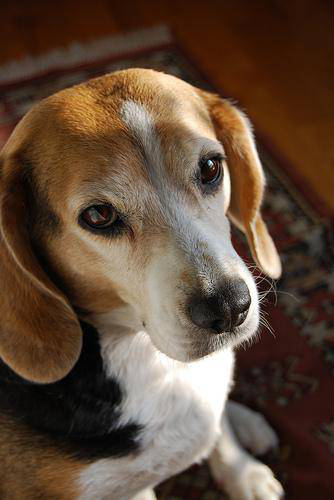

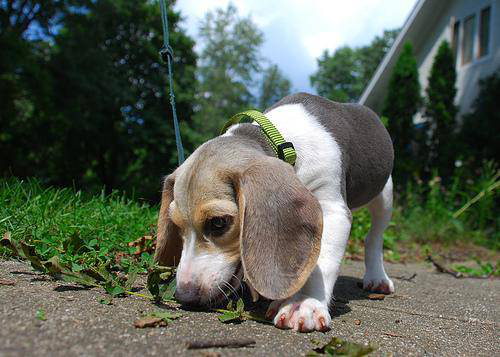

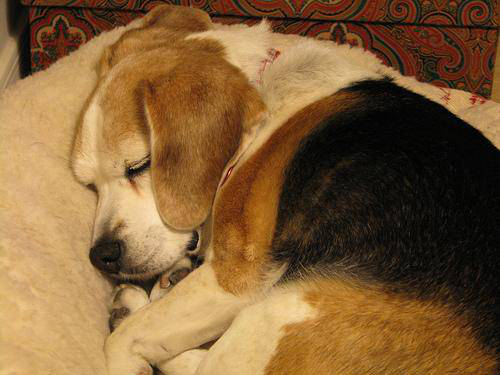

In [4]:
#LABELS_URL = "https://www.dropbox.com/s/httj9tburv389qh/train_labels.csv?dl=1"
#LABELS_FILE = tf.keras.utils.get_file("labels.csv", LABELS_URL)

#LABELS_FILE = "/kaggle/input/aw18-19/train_labels.csv"
LABELS_FILE = "/content/drive/My Drive/dogs/train_labels.csv"

df = pd.read_csv(LABELS_FILE)
print(df.dtypes)
print(df.head())

CLASS_NAMES = np.unique(df.breed)
class_count = len(CLASS_NAMES)
print("Number of classes: ", class_count)
print("Classes:")
print(CLASS_NAMES)

#data_dir = tf.keras.utils.get_file(origin='https://www.dropbox.com/s/mfb1plls1gusr4m/Dataset.zip?dl=1',
#                                         fname='dog_breeds', extract=True)
data_dir = "/content/drive/My Drive/dogs/Dataset/train"
data_dir = pathlib.Path(data_dir)

image_count = len(list(data_dir.glob('*/*.jpg')))
print("Number of images:", image_count)

beagle = list(data_dir.glob('beagle/*'))
print("Number of beagle images:", len(beagle))

for image_path in beagle[:3]:
    display.display(Image.open(str(image_path)))

#Image Loading

In [0]:
BATCH_SIZE = 32
IMG_HEIGHT = 224
IMG_WIDTH = 224
STEPS_PER_EPOCH = np.ceil(image_count / BATCH_SIZE)
AUTOTUNE = tf.data.experimental.AUTOTUNE

In [6]:
# get a dataset of all files matching the pattern
list_ds = tf.data.Dataset.list_files(str(data_dir/'*/*'))

for f in list_ds.take(5):
  print(f.numpy())

afghan_hound
airedale
australian_terrier
basenji
beagle
bernese_mountain_dog
blenheim_spaniel
border_terrier
cairn
chow
entlebucher
great_pyrenees
ibizan_hound
irish_wolfhound
italian_greyhound
japanese_spaniel
lakeland_terrier
leonberg
lhasa
maltese_dog
miniature_pinscher
newfoundland
norwegian_elkhound
papillon
pembroke
pomeranian
pug
saluki
samoyed
scottish_deerhound
shih-tzu
siberian_husky
silky_terrier
tibetan_terrier
whippet
b'/content/drive/My Drive/dogs/Dataset/train/pembroke/1586326d52312228c20c3599feb72d7a.jpg'
b'/content/drive/My Drive/dogs/Dataset/train/tibetan_terrier/3f0ef4652899749d98df8a05a576239b.jpg'
b'/content/drive/My Drive/dogs/Dataset/train/norwegian_elkhound/9e31cc4d5a9f9e240ee8dcd15b2b537d.jpg'
b'/content/drive/My Drive/dogs/Dataset/train/border_terrier/a31f36d3aa5d81004b0d454902e40889.jpg'
b'/content/drive/My Drive/dogs/Dataset/train/airedale/5a77c52d7a56a0c397ac6a357c4df915.jpg'


In [0]:
def get_label(file_path):
  # convert the path to a list of path components
  parts = tf.strings.split(file_path, os.path.sep)
  # The second to last is the class-directory
  return parts[-2] == CLASS_NAMES

def decode_img(img):
  # convert the compressed string to a 3D uint8 tensor
  img = tf.image.decode_jpeg(img, channels=3)
  # Use `convert_image_dtype` to convert to floats in the [0,1] range.
  img = tf.image.convert_image_dtype(img, tf.float32)
  # resize the image to the desired size.
  return tf.image.resize(img, [IMG_WIDTH, IMG_HEIGHT])

def process_path(file_path):
  label = get_label(file_path)
  # load the raw data from the file as a string
  img = tf.io.read_file(file_path)
  img = decode_img(img)
  return img, label  

In [61]:
# apply process_path function to each element of this dataset, and return a new
# dataset containing the transformed elements, in the same order as they 
# appeared in the input.
# set `num_parallel_calls` so multiple images are loaded/processed in parallel.
labeled_ds = list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

for image, label in labeled_ds.take(3):
  #print("Image tensor: ", image)
  #print("Label tensor:", label)
  print("Image shape: ", image.numpy().shape)
  print("Label: ", label)

Image shape:  (224, 224, 3)
Label:  tf.Tensor(
[ True False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False], shape=(35,), dtype=bool)
Image shape:  (224, 224, 3)
Label:  tf.Tensor(
[False False False False False False False  True False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False], shape=(35,), dtype=bool)
Image shape:  (224, 224, 3)
Label:  tf.Tensor(
[False False False False False False False False False False False False
 False False False False False False False False False  True False False
 False False False False False False False False False False False], shape=(35,), dtype=bool)


# Data Preparation

In [0]:
def prepare_for_training(ds, cache=True, shuffle_buffer_size=1000):
  # use `.cache(filename)` to cache preprocessing work for datasets that don't
  # fit in memory.
  if cache:
    if isinstance(cache, str):
      ds = ds.cache(cache)
    else:
      ds = ds.cache()

  ds = ds.shuffle(buffer_size=shuffle_buffer_size)

  # Repeat forever
  ds = ds.repeat()

  ds = ds.batch(BATCH_SIZE)

  # `prefetch` lets the dataset fetch batches in the background while the model
  # is training.
  ds = ds.prefetch(buffer_size=AUTOTUNE)

  return ds


def show_batch(image_batch, label_batch):
  plt.figure(figsize=(10, 10))
  for n in range(25):
      ax = plt.subplot(5, 5, n + 1)
      plt.imshow(image_batch[n])
      plt.title(CLASS_NAMES[label_batch[n] == 1][0].title())
      plt.axis('off')

In [54]:
train_ds = prepare_for_training(labeled_ds, cache="./dogs.tfcache")
print(train_ds)
train_ds.element_spec

<PrefetchDataset shapes: ((None, 224, 224, 3), (None, 35)), types: (tf.float32, tf.bool)>


(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 35), dtype=tf.bool, name=None))

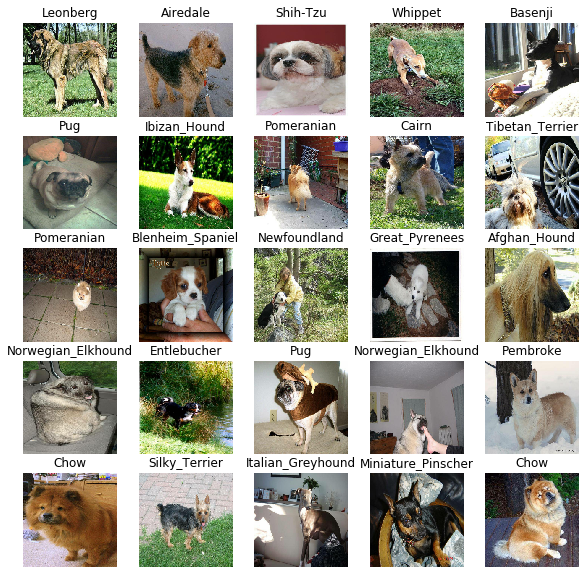

In [55]:
image_batch, label_batch = next(iter(train_ds))

show_batch(image_batch.numpy(), label_batch.numpy())

In [0]:
import time
default_timeit_steps = 1000

def timeit(ds, steps=default_timeit_steps):
  start = time.time()
  it = iter(ds)
  for i in range(steps):
    batch = next(it)
    if i%10 == 0:
      print('.', end='')
  print()
  end = time.time()

  duration = end-start
  print("{} batches: {} s".format(steps, duration))
  print("{:0.5f} Images/s".format(BATCH_SIZE * steps / duration))

In [25]:
timeit(train_ds)

....................................................................................................
1000 batches: 186.29769611358643 s
171.76809 Images/s


# Model

In [50]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', 
                        input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(class_count, activation='softmax'))

model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 222, 222, 32)      896       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 111, 111, 32)      0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 109, 109, 64)      18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 54, 54, 64)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 52, 52, 64)        36928     
_________________________________________________________________
flatten_5 (Flatten)          (None, 173056)            0         
_________________________________________________________________
dense_6 (Dense)              (None, 64)               

In [57]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(train_ds, 
                    epochs=10,
                    verbose=1,
                    steps_per_epoch=STEPS_PER_EPOCH
                    )

ValueError: ignored

In [56]:
loss, accuracy = model.evaluate(train_ds, steps=STEPS_PER_EPOCH)
print("Loss :", loss)
print("Accuracy :", accuracy)

69/69 [==============================] - 2s 36ms/step - loss: 0.0160 - accuracy: 0.9973
Loss : 0.016039252279501787
Accuracy : 0.9972826
